# 9. NLP - 텍스트를 위한 인공 신경망

## 9-1. 순차 데이터와 순환 신경망

- 순차 데이터 sequential data: 텍스트, 시계열 데이터처럼 순서에 의미가 있는 데이터
- 순차 데이터를 다루기 위해서는 이전에 입력한 데이터를 기억하는 기능이 필요하다
- FFDD Feedforward neural network: 피드포워드 신경망, 데이터 흐름이 앞으로만 전달되는 신경망
- RNN 순환 신경망 recurrent neural network: 순차 데이터에 잘 맞는 인공 신경망. 순환층을 1개 이상 사용한 신경망
- 셀: RNN에서 순환층을 셀이라고 부른다
- 은닉 상태: 셀의 출력 -> 은닉 상태가 다음 층으로 전달된다 + 셀이 타음 스텝 데이터를 처리할 때 재사용된다

## 9-2. 순환 신경망으로 IMDB 리뷰 분류하기

- NLP Natural Language Processing
- 음성 인식, 기계 번역, 감성 분석 등
- 훈련 데이터를 "corpus"라고 부름
- 단어에 대응하는 고유한 정수를 부여한다, 이를 "token"이라고 함

데이터 불러오기

In [1]:
from tensorflow.keras.datasets import imdb
(train_input, train_target), (test_input, test_target) = imdb.load_data(num_words=500)

17464789/17464789 [==============================] - 20s 1us/step


In [2]:
print(train_input.shape, test_input.shape)

(25000,) (25000,)


In [3]:
print(train_input[0])

[1, 14, 22, 16, 43, 2, 2, 2, 2, 65, 458, 2, 66, 2, 4, 173, 36, 256, 5, 25, 100, 43, 2, 112, 50, 2, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 2, 2, 17, 2, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2, 19, 14, 22, 4, 2, 2, 469, 4, 22, 71, 87, 12, 16, 43, 2, 38, 76, 15, 13, 2, 4, 22, 17, 2, 17, 12, 16, 2, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2, 2, 16, 480, 66, 2, 33, 4, 130, 12, 16, 38, 2, 5, 25, 124, 51, 36, 135, 48, 25, 2, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 2, 15, 256, 4, 2, 7, 2, 5, 2, 36, 71, 43, 2, 476, 26, 400, 317, 46, 7, 4, 2, 2, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2, 56, 26, 141, 6, 194, 2, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 2, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 2, 88, 12, 16, 283, 5, 16, 2, 113, 103, 32, 15, 16, 2, 19, 178, 32]


In [4]:
print(train_target[:20]) # 0은 부정, 1은 긍정

[1 0 0 1 0 0 1 0 1 0 1 0 0 0 0 0 1 1 0 1]


훈련 셋과 검증 셋 분리하기

In [5]:
from sklearn.model_selection import train_test_split
train_input, val_input, train_target, val_target = train_test_split(
    train_input, train_target, test_size=0.2, random_state=42
)

239.00925 178.0


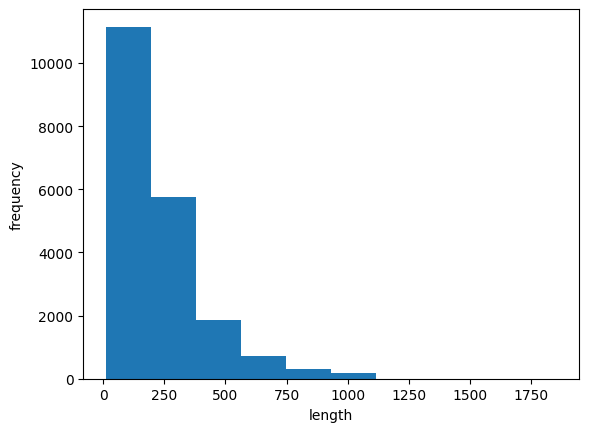

In [6]:
import numpy as np
import matplotlib.pyplot as plt

lengths = np.array([len(x) for x in train_input])
print(np.mean(lengths), np.median(lengths))

plt.hist(lengths)
plt.xlabel("length")
plt.ylabel("frequency")
plt.show()

100개 단어 이하인 리뷰만 사용하기

100보다 짧은 리뷰는 토큰 0으로 패딩을 채운다

100보다 긴 리뷰는 앞부분부터 자른다

In [9]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
train_seq = pad_sequences(train_input, maxlen=100)
val_seq = pad_sequences(val_input, maxlen=100)
print(train_seq.shape)

(20000, 100)


### 순환 신경망 만들기

- 가장 간단한 순환층 클래스: SimpleRNN
  

In [10]:
from tensorflow import keras
model = keras.Sequential()
model.add(keras.layers.SimpleRNN(8, # 뉴련 개수
                                 input_shape=(100, 500), # input 차원(샘플 길이, 원핫인코딩 길이)
                                 activation="tanh")) # 활성화 함수 tanh
model.add(keras.layers.Dense(1, activation="sigmoid"))

원핫 인코딩

In [14]:
train_oh = keras.utils.to_categorical(train_seq)
val_oh = keras.utils.to_categorical(val_seq)
print(train_oh.shape)

(20000, 100, 500)


In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 8)                 4072      
                                                                 
 dense (Dense)               (None, 1)                 9         
                                                                 
Total params: 4,081
Trainable params: 4,081
Non-trainable params: 0
_________________________________________________________________


학습시키기

In [16]:
rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)
model.compile(
    optimizer=rmsprop, 
    loss="binary_crossentropy",
    metrics=["accuracy"]
)
checkpoint_cb = keras.callbacks.ModelCheckpoint("best-simplernn-model.h5",
                                                save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3, 
                                                  restore_best_weights=True)
history = model.fit(train_oh, train_target, 
                    epochs=100, 
                    batch_size=64, 
                    validation_data=(val_oh, val_target),
                    callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 [==============================] - 10s 28ms/step - loss: 0.7023 - accuracy: 0.4967 - val_loss: 0.6996 - val_accuracy: 0.5046
Epoch 2/100
313/313 [==============================] - 9s 28ms/step - loss: 0.6966 - accuracy: 0.5051 - val_loss: 0.6960 - val_accuracy: 0.5090
Epoch 3/100
313/313 [==============================] - 9s 29ms/step - loss: 0.6937 - accuracy: 0.5169 - val_loss: 0.6938 - val_accuracy: 0.5144
Epoch 4/100
313/313 [==============================] - 11s 34ms/step - loss: 0.6891 - accuracy: 0.5375 - val_loss: 0.6865 - val_accuracy: 0.5480
Epoch 5/100
313/313 [==============================] - 11s 34ms/step - loss: 0.6784 - accuracy: 0.5874 - val_loss: 0.6769 - val_accuracy: 0.5878
Epoch 6/100
313/313 [==============================] - 15s 47ms/step - loss: 0.6678 - accuracy: 0.6219 - val_loss: 0.6677 - val_accuracy: 0.6100
Epoch 7/100
313/313 [==============================] - 13s 43ms/step - loss: 0.6566 - accuracy: 0.6517 - val_loss: 0.6550 - val_accu

훈련 손실과 검증 손실

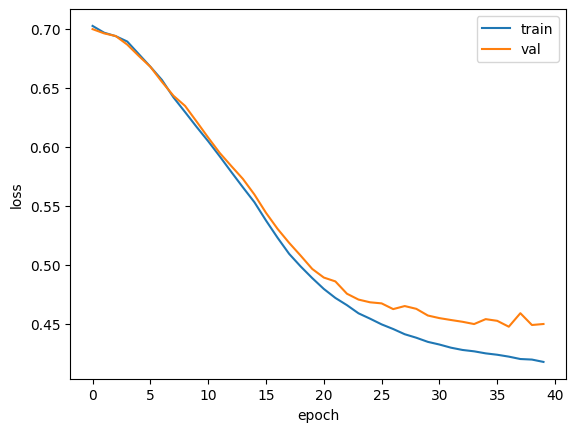

In [17]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend(["train", "val"])
plt.show()

- 단어 임베딩 사용하기 word embedding
- 각 단어를 고정된 크기의 실수 벡터로 바꿈


In [18]:
model2 = keras.Sequential()
model2.add(keras.layers.Embedding(500, 16, input_length=100))
model2.add(keras.layers.SimpleRNN(8))
model2.add(keras.layers.Dense(1, activation="sigmoid"))

In [19]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 16)           8000      
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 8)                 200       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 8,209
Trainable params: 8,209
Non-trainable params: 0
_________________________________________________________________


학습시키기

In [20]:
rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)
model2.compile(optimizer=rmsprop, loss="binary_crossentropy", metrics=["accuracy"])
checkpoint_cb = keras.callbacks.ModelCheckpoint("best-embedding-model.h5",
                                                save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3, 
                                                  restore_best_weights=True)
history = model2.fit(train_seq, train_target, 
                     epochs=100, batch_size=64, 
                     validation_data=(val_seq, val_target), 
                     callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 [==============================] - 9s 24ms/step - loss: 0.6947 - accuracy: 0.5099 - val_loss: 0.6892 - val_accuracy: 0.5406
Epoch 2/100
313/313 [==============================] - 8s 25ms/step - loss: 0.6749 - accuracy: 0.6126 - val_loss: 0.6651 - val_accuracy: 0.6582
Epoch 3/100
313/313 [==============================] - 10s 31ms/step - loss: 0.6553 - accuracy: 0.6882 - val_loss: 0.6513 - val_accuracy: 0.6948
Epoch 4/100
313/313 [==============================] - 11s 36ms/step - loss: 0.6410 - accuracy: 0.7179 - val_loss: 0.6404 - val_accuracy: 0.7160
Epoch 5/100
313/313 [==============================] - 11s 34ms/step - loss: 0.6283 - accuracy: 0.7362 - val_loss: 0.6292 - val_accuracy: 0.7338
Epoch 6/100
313/313 [==============================] - 8s 27ms/step - loss: 0.6170 - accuracy: 0.7466 - val_loss: 0.6189 - val_accuracy: 0.7404
Epoch 7/100
313/313 [==============================] - 7s 23ms/step - loss: 0.6057 - accuracy: 0.7561 - val_loss: 0.6114 - val_accura

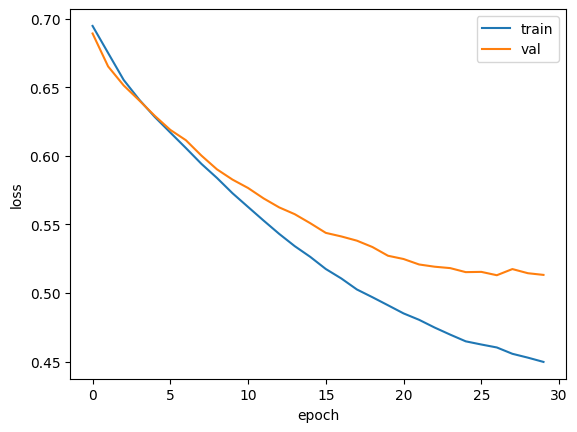

In [21]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend(["train", "val"])
plt.show()

## 9-3. LSTM과 GRU 셀

- RNN에서 빼놓을 수 없는 기술인 LSTM과 GRU
- LSTM은 Long Short-Term Memory의 약자
- GRU는 Gated Recurrent Unit의 약자

### LSTM Long Short-Term Memory

![image](https://user-images.githubusercontent.com/81140673/224916276-28afb3b5-9faf-485b-ac0f-7daa1caa9449.png)


- 타임스탭이 긴 데이터를 효과적으로 학습하기 위해 고안된 순환층

데이터 불러오기

In [22]:
from tensorflow.keras.datasets import imdb
from sklearn.model_selection import train_test_split
(train_input, train_target), (test_input, test_target) = imdb.load_data(num_words=100)
train_input, val_input, train_target, val_target = train_test_split(
    train_input, train_target, test_size=0.2, random_state=42
)

데이터 전처리 -> 샘플 길이 맞추기

In [23]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
train_seq = pad_sequences(train_input, maxlen=100)
val_seq = pad_sequences(val_input, maxlen=100)

모델 만들기

In [24]:
from tensorflow import keras
model = keras.Sequential()
model.add(keras.layers.Embedding(500, 16, input_length=100))
model.add(keras.layers.LSTM(8))
model.add(keras.layers.Dense(1, activation="sigmoid"))

In [25]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 16)           8000      
                                                                 
 lstm (LSTM)                 (None, 8)                 800       
                                                                 
 dense_2 (Dense)             (None, 1)                 9         
                                                                 
Total params: 8,809
Trainable params: 8,809
Non-trainable params: 0
_________________________________________________________________


훈련시키기

In [26]:
rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)
model.compile(optimizer=rmsprop, 
              loss="binary_crossentropy",
              metrics=["accuracy"])
checkpoint_cb = keras.callbacks.ModelCheckpoint("best-lstm-model.h5",
                                                save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3, 
                                                  restore_best_weights=True)
history = model.fit(train_seq, train_target, 
                    epochs=100, 
                    batch_size=64, 
                    validation_data=(val_seq, val_target),
                    callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 [==============================] - 15s 39ms/step - loss: 0.6930 - accuracy: 0.5115 - val_loss: 0.6927 - val_accuracy: 0.5284
Epoch 2/100
313/313 [==============================] - 12s 39ms/step - loss: 0.6919 - accuracy: 0.5513 - val_loss: 0.6911 - val_accuracy: 0.5974
Epoch 3/100
313/313 [==============================] - 13s 42ms/step - loss: 0.6890 - accuracy: 0.6032 - val_loss: 0.6862 - val_accuracy: 0.6252
Epoch 4/100
313/313 [==============================] - 12s 40ms/step - loss: 0.6739 - accuracy: 0.6398 - val_loss: 0.6549 - val_accuracy: 0.6452
Epoch 5/100
313/313 [==============================] - 16s 53ms/step - loss: 0.6425 - accuracy: 0.6512 - val_loss: 0.6372 - val_accuracy: 0.6538
Epoch 6/100
313/313 [==============================] - 18s 56ms/step - loss: 0.6307 - accuracy: 0.6633 - val_loss: 0.6271 - val_accuracy: 0.6618
Epoch 7/100
313/313 [==============================] - 16s 51ms/step - loss: 0.6222 - accuracy: 0.6676 - val_loss: 0.6197 - val_ac

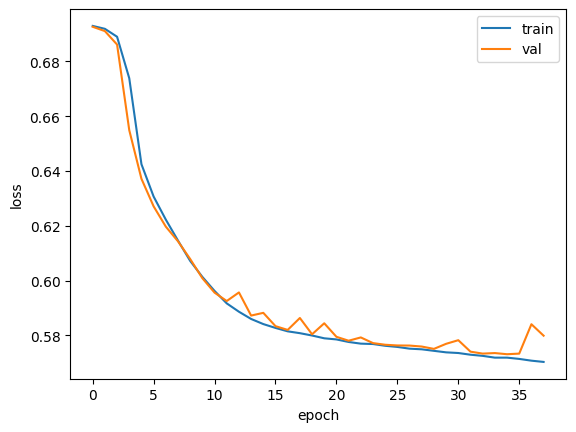

In [27]:
import matplotlib.pyplot as plt
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend(["train", "val"])
plt.show()

- 2개의 층을 연결하기
- 이때, 마지막 층을 제외하고는 모든 타임스텝의 은닉 상태를 전달해야 한다

In [28]:
model3 = keras.Sequential()
model3.add(keras.layers.Embedding(500, 16, input_length=100))
model3.add(keras.layers.LSTM(8, dropout=0.3, return_sequences=True))
model3.add(keras.layers.LSTM(8, dropout=0.3))
model3.add(keras.layers.Dense(1, activation="sigmoid"))

In [29]:
model3.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 16)           8000      
                                                                 
 lstm_1 (LSTM)               (None, 100, 8)            800       
                                                                 
 lstm_2 (LSTM)               (None, 8)                 544       
                                                                 
 dense_3 (Dense)             (None, 1)                 9         
                                                                 
Total params: 9,353
Trainable params: 9,353
Non-trainable params: 0
_________________________________________________________________


훈련시키기

In [30]:
rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)
model3.compile(optimizer=rmsprop, 
               loss="binary_crossentropy",
               metrics=["accuracy"])
checkpoint_cb = keras.callbacks.ModelCheckpoint("best-2rnn-model.h5",
                                                save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3, 
                                                  restore_best_weights=True)
history = model3.fit(train_seq, train_target, 
                     epochs=100, batch_size=64, 
                     validation_data=(val_seq, val_target),
                     callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 [==============================] - 36s 93ms/step - loss: 0.6930 - accuracy: 0.5062 - val_loss: 0.6930 - val_accuracy: 0.4930
Epoch 2/100
313/313 [==============================] - 25s 79ms/step - loss: 0.6924 - accuracy: 0.5232 - val_loss: 0.6920 - val_accuracy: 0.5218
Epoch 3/100
313/313 [==============================] - 24s 78ms/step - loss: 0.6902 - accuracy: 0.5691 - val_loss: 0.6883 - val_accuracy: 0.5786
Epoch 4/100
313/313 [==============================] - 24s 77ms/step - loss: 0.6810 - accuracy: 0.6102 - val_loss: 0.6695 - val_accuracy: 0.6348
Epoch 5/100
313/313 [==============================] - 28s 90ms/step - loss: 0.6460 - accuracy: 0.6444 - val_loss: 0.6245 - val_accuracy: 0.6586
Epoch 6/100
313/313 [==============================] - 26s 84ms/step - loss: 0.6220 - accuracy: 0.6583 - val_loss: 0.6118 - val_accuracy: 0.6706
Epoch 7/100
313/313 [==============================] - 25s 80ms/step - loss: 0.6121 - accuracy: 0.6658 - val_loss: 0.6046 - val_ac

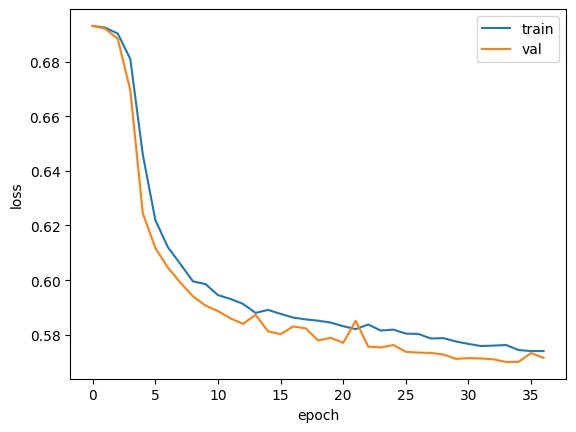

In [31]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend(["train", "val"])
plt.show()

- GRU Gated Recurrent Unit
- LSTM의 간소화된 버전
- 은닉 상태 하나만 포함한다


In [32]:
model4 = keras.Sequential()
model4.add(keras.layers.Embedding(500, 16, input_length=100))
model4.add(keras.layers.GRU(8))
model4.add(keras.layers.Dense(1, activation="sigmoid"))

In [33]:
model4.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 100, 16)           8000      
                                                                 
 gru (GRU)                   (None, 8)                 624       
                                                                 
 dense_4 (Dense)             (None, 1)                 9         
                                                                 
Total params: 8,633
Trainable params: 8,633
Non-trainable params: 0
_________________________________________________________________


훈련시키기

In [34]:
rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)
model4.compile(optimizer=rmsprop, 
               loss="binary_crossentropy",
               metrics=["accuracy"])
checkpoint_cb = keras.callbacks.ModelCheckpoint("best-gru-model.h5",
                                                save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3, 
                                                  restore_best_weights=True)
history = model4.fit(train_seq, train_target, 
                     epochs=100, 
                     batch_size=64, 
                     validation_data=(val_seq, val_target),
                     callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 [==============================] - 16s 42ms/step - loss: 0.6929 - accuracy: 0.5105 - val_loss: 0.6928 - val_accuracy: 0.5216
Epoch 2/100
313/313 [==============================] - 15s 48ms/step - loss: 0.6924 - accuracy: 0.5258 - val_loss: 0.6923 - val_accuracy: 0.5392
Epoch 3/100
313/313 [==============================] - 14s 45ms/step - loss: 0.6918 - accuracy: 0.5379 - val_loss: 0.6918 - val_accuracy: 0.5304
Epoch 4/100
313/313 [==============================] - 13s 41ms/step - loss: 0.6911 - accuracy: 0.5418 - val_loss: 0.6911 - val_accuracy: 0.5412
Epoch 5/100
313/313 [==============================] - 12s 39ms/step - loss: 0.6901 - accuracy: 0.5505 - val_loss: 0.6900 - val_accuracy: 0.5672
Epoch 6/100
313/313 [==============================] - 13s 42ms/step - loss: 0.6888 - accuracy: 0.5583 - val_loss: 0.6887 - val_accuracy: 0.5706
Epoch 7/100
313/313 [==============================] - 13s 41ms/step - loss: 0.6872 - accuracy: 0.5617 - val_loss: 0.6870 - val_ac

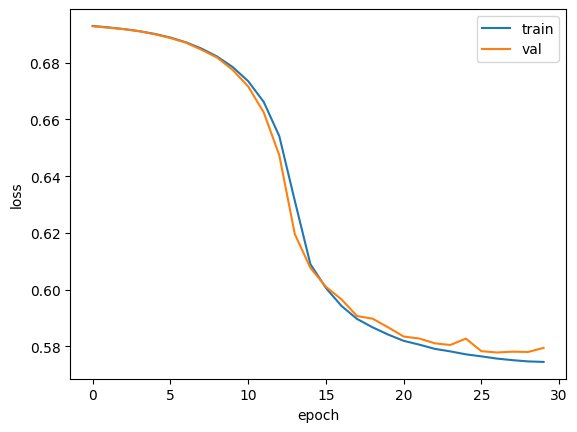

In [35]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend(["train", "val"])
plt.show()